In [256]:
import numpy as np
import matplotlib.pyplot as plt
import gsd.hoomd
import hoomd
import os

In [269]:
def run_single_simulation(seed, n_steps=100000, log_period=1000, force_magnitude=10, rotational_diffusion=10, dt=0.0001):
    """Run a single simulation and return position trajectory"""
    
    # Setup initial conditions
    N_particles = 1
    L = 1000
    position = [[0, 0, 0]]
    
    # Create frame
    frame = gsd.hoomd.Frame()
    frame.particles.N = N_particles
    frame.particles.position = position[0:N_particles]
    frame.particles.typeid = [0] * N_particles
    frame.particles.types = ["A"]
    frame.particles.moment_inertia = [[1.0, 1.0, 1.0]] * N_particles  # Enable rotation
    frame.configuration.box = [L, L, L, 0, 0, 0]
    
    # Clean up any existing files
    filename = f"lattice_seed_{seed}.gsd"
    if os.path.exists(filename):
        os.remove(filename)
    
    with gsd.hoomd.open(name=filename, mode="x") as f:
        f.append(frame)
    
    # Create simulation
    cpu = hoomd.device.CPU()
    simulation = hoomd.Simulation(device=cpu, seed=seed)
    simulation.create_state_from_gsd(filename=filename)
    
    # Set up integrator and forces
    integrator = hoomd.md.Integrator(dt=dt, integrate_rotational_dof=True)
    
    # Active force
    active_filter = hoomd.filter.Type(['A'])
    active_force = hoomd.md.force.Active(filter=active_filter)
    active_force.active_force['A'] = (force_magnitude, 0.0, 0.0)
    active_force.active_torque['A'] = (0.0, 0.0, 0.0)
    integrator.forces.append(active_force)
    
    # Brownian dynamics with rotational diffusion
    langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
    langevin.gamma['A'] = 1.0
    langevin.gamma_r['A'] = (rotational_diffusion, rotational_diffusion, rotational_diffusion)
    integrator.methods.append(langevin)
    simulation.operations.integrator = integrator
    
    # Store positions
    positions = []
    times = []
    
    # Get initial position
    snapshot = simulation.state.get_snapshot()
    initial_position = snapshot.particles.position[0].copy()
    positions.append(initial_position)
    times.append(0)
    
    # Run simulation with logging
    for step in range(0, n_steps, log_period):
        simulation.run(log_period)
        snapshot = simulation.state.get_snapshot()
        positions.append(snapshot.particles.position[0].copy())
        times.append(simulation.timestep)
    
    # Clean up
    if os.path.exists(filename):
        os.remove(filename)
    
    return np.array(times), np.array(positions)

In [270]:
def calculate_msd(positions):
    """Calculate mean squared displacement from position trajectory"""
    initial_pos = positions[0]
    displacements = positions - initial_pos
    msd = np.sum(displacements**2, axis=1)
    return msd

In [271]:
def run_multiple_simulations(n_runs=10, n_steps=100000, log_period=1000, 
                           force_magnitude=10, rotational_diffusion=10, dt=0.0001):
    """Run multiple simulations and calculate average MSD"""
    
    all_msds = []
    all_times = []
    
    print(f"Running {n_runs} simulations...")
    
    for run_idx in range(n_runs):
        if run_idx % 10 == 0:
            print(f"Simulation {run_idx + 1}/{n_runs}")
        
        # Use different seed for each run
        seed = run_idx + 1
        times, positions = run_single_simulation(
            seed=seed, 
            n_steps=n_steps, 
            log_period=log_period,
            force_magnitude=force_magnitude,
            rotational_diffusion=rotational_diffusion,
            dt=dt
        )
        
        msd = calculate_msd(positions)
        all_msds.append(msd)
        all_times.append(times)
    
    # Convert to arrays and calculate statistics
    min_length = min(len(msd) for msd in all_msds)
    all_msds = [msd[:min_length] for msd in all_msds]
    all_times = [times[:min_length] for times in all_times]
    
    all_msds = np.array(all_msds)
    avg_times = np.mean(all_times, axis=0)
    avg_msd = np.mean(all_msds, axis=0)
    
    return avg_times, avg_msd


In [277]:
def plot_msd_results(times, avg_msd, dt):
    """Plot MSD results"""
    physical_times = times * dt
    
    plt.figure(figsize=(8, 6))
    plt.loglog(physical_times[1:], avg_msd[1:], 'b-', linewidth=2)
    plt.xlabel('Time (s)')
    plt.ylabel('MSD')
    plt.grid(True, alpha=0.3)
    plt.show()


Running 200 simulations...
Simulation 1/200
Simulation 11/200
Simulation 21/200
Simulation 31/200
Simulation 41/200
Simulation 51/200
Simulation 61/200
Simulation 71/200
Simulation 81/200
Simulation 91/200
Simulation 101/200
Simulation 111/200
Simulation 121/200
Simulation 131/200
Simulation 141/200
Simulation 151/200
Simulation 161/200
Simulation 171/200
Simulation 181/200
Simulation 191/200


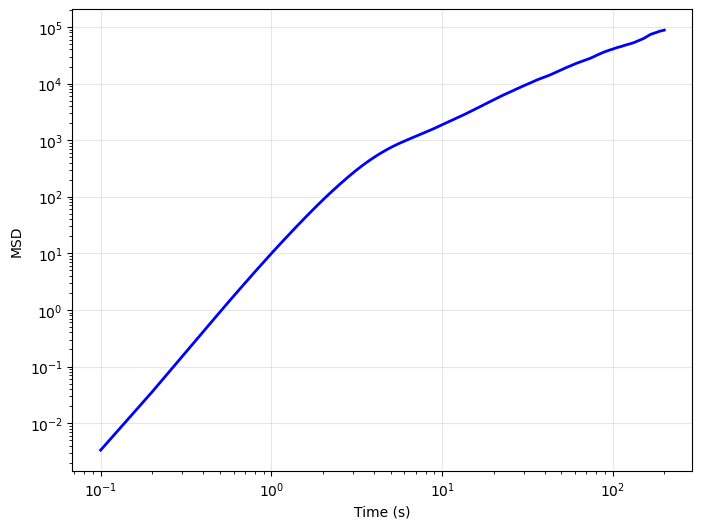

In [280]:
if __name__ == "__main__":
    # Set parameters here
    n_runs = 200
    n_steps = 200000
    log_period = 100
    force_magnitude = 8.0
    rotational_diffusion = 0.05
    dt = 0.001
    
    # Run simulations
    times, avg_msd = run_multiple_simulations(
        n_runs=n_runs,
        n_steps=n_steps,
        log_period=log_period,
        force_magnitude=force_magnitude,
        rotational_diffusion=rotational_diffusion,
        dt=dt
    )
    
    # Plot results
    plot_msd_results(times, avg_msd, dt)